[PyTorch (10) Autoencoder](http://aidiary.hatenablog.com/entry/20180225/1519520981)

28x28の画像 ``x`` をencoder（ニューラルネット）で2次元データ ``z`` にまで圧縮し、その2次元データから元の画像をdecoder（別のニューラルネット）で復元する。ただし、一度情報を圧縮してしまうので完全に元の画像には戻らず再構成した画像 ``xhat`` は入力画像の近似となる。

In [1]:
import os
import numpy as np
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image


In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cuda'

In [3]:
# hyperparameters
num_epochs = 100
batch_size = 128
learning_rate = 0.001
out_dir = "./autoencoder"


In [4]:
if not os.path.exists(out_dir):
    os.mkdir(out_dir)


データ変換関数。MNISTは ``ToTensor()`` すると ``[0, 1]`` になるので0.5を引いて0.5で割って ``[-1, 1]`` の範囲に変換する。

``image = (image - mean) / std``

In [5]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = MNIST("./data", download=True, transform=img_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


Autoencoderのモデルを作成。``encoder``` と ``decoder``` を定義する。別々に定義しておくとEncoder・Decoderを独立して使えるので便利（あとでEncoderのみ使う例を示す）。

Encoderは普通の多層ニューラルネットで``784 => 128 => 64 => 12 => 2`` と2次元まで圧縮してみた。**2次元まで圧縮すると潜在空間を描画できる**。逆にDecoderは``2 => 12 => 64 => 128 => 784`` と元の画像サイズまで戻す。入力画像は ``[-1, 1]`` に標準化したので出力の活性化関数には ```tanh``` を使う（```tanh```は出力の範囲が ```[-1, 1]```）。EncoderとDecoderで重みは共有せずにそれぞれ別に学習する

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()
model.to(device)
        


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=12, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=128, out_features=784, bias=True)
  )
)

変換したテンソルを元の画像に戻す関数。

In [7]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)  # Tensor.clamp(x, y) : argmax([x, Tensor, y])  like ReLu function
    x = x.view(x.size(0), 1, 28, 28)
    return x


訓練ループ。Autoencoderはラベルは使わない。ターゲットは入力画像そのものとなる。Loss関数は入力と出力の間の平均二乗誤差とする。つまり、**出力が入力に近づくように学習する**。

[Weight_decacyとは](https://qiita.com/supersaiakujin/items/97f4c0017ef76e547976)

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=1e-5)

loss_list = []

for epoch in range(num_epochs):
    for (img, _) in train_loader:
        x = img.view(img.size(0), -1)  # flatten (batch_size, 784)
        x = x.to(device)

        # 勾配を0に
        optimizer.zero_grad()

        xhat = model(x)

        # 出力画像（再構成画像）と入力画像の間でlossを計算
        loss = criterion(xhat, x)
        loss.backward()
        optimizer.step()

        # logging
        # print(loss)
        loss_list.append(loss.item())

    print('epoch [{}/{}], loss: {:.4f}'.format(
        epoch + 1,
        num_epochs,
        loss.item()))

    # 10epochごとに再構成された画像(xhat)を描画する
    if epoch % 10 == 0:
        pic = to_img(xhat.cpu().data)
        save_image(pic, './{}/image_{}.png'.format(out_dir, epoch))

np.save('./{}/loss_list.npy'.format(out_dir), np.array(loss_list))  # lossの履歴を保存
torch.save(model.state_dict(), './{}/autoencoder.pth'.format(out_dir))

epoch [1/100], loss: 0.2325
epoch [2/100], loss: 0.2111
epoch [3/100], loss: 0.1971
epoch [4/100], loss: 0.1876
epoch [5/100], loss: 0.1739
epoch [6/100], loss: 0.1602
epoch [7/100], loss: 0.1713
epoch [8/100], loss: 0.1554
epoch [9/100], loss: 0.1712
epoch [10/100], loss: 0.1572
epoch [11/100], loss: 0.1655
epoch [12/100], loss: 0.1627
epoch [13/100], loss: 0.1623
epoch [14/100], loss: 0.1555
epoch [15/100], loss: 0.1569
epoch [16/100], loss: 0.1564
epoch [17/100], loss: 0.1631
epoch [18/100], loss: 0.1644
epoch [19/100], loss: 0.1646
epoch [20/100], loss: 0.1652
epoch [21/100], loss: 0.1515
epoch [22/100], loss: 0.1626
epoch [23/100], loss: 0.1552
epoch [24/100], loss: 0.1539
epoch [25/100], loss: 0.1520
epoch [26/100], loss: 0.1612
epoch [27/100], loss: 0.1606
epoch [28/100], loss: 0.1601
epoch [29/100], loss: 0.1483
epoch [30/100], loss: 0.1621
epoch [31/100], loss: 0.1551
epoch [32/100], loss: 0.1521
epoch [33/100], loss: 0.1499
epoch [34/100], loss: 0.1539
epoch [35/100], loss: 0

### 潜在空間の可視化
テストデータ10000画像をEncoderで潜在空間にマッピングして各画像がどのように分布するか可視化してみる。Encoderしか使わない。先にモデルを定義しておくと、``model.encoder()``でエンコーダだけ呼び出せる

In [12]:
model.load_state_dict(torch.load("{}/autoencoder.pth".format(out_dir), map_location=lambda storage, loc:storage))

test_dataset = MNIST("./data", download=True, train=False, transform=img_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)

images, labels = iter(test_loader).next()
images = images.view(10000, -1)

# 推論
z = model.encoder(images.to(device)).data.cpu().numpy()

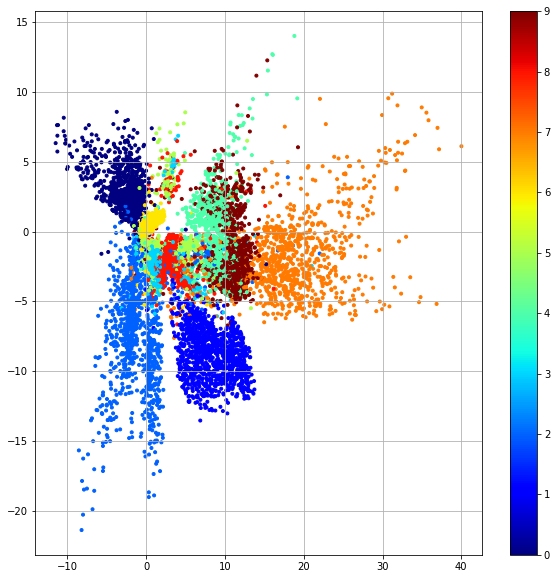

In [13]:
import pylab
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], marker=".", c=labels.numpy(), cmap=pylab.cm.jet)
plt.colorbar()
plt.grid()